#Udacity MLE Nanodegree Capstone - Training 
Light-weight Data ModeEfficientnet and Fast.ai for Chest X-Ray (CXR) classification task; light-weight modeling for detecting upper-respitorty viral infenctions from Chests. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

###Environment Setup:

In [2]:
!pip install pthflops
!pip install plotly_express
!pip install pytorchcv

  Created wheel for pthflops: filename=pthflops-0.2.2-cp36-none-any.whl size=5108 sha256=4bfe30736dd7343b6866b0d9253faf1dd989099f1949b100417deea324cb6728
  Stored in directory: /root/.cache/pip/wheels/f8/c8/14/8a85a906c6eba9ed3e1c331c4f66dc8c43a7b4953a88e04397
Successfully built pthflops
     |████████████████████████████████| 440kB 8.0MB/s 


In [3]:
with open('/content/common.py','r') as writer_file:
    contents_to_write = writer_file.read()
with open('/usr/local/lib/python3.6/dist-packages/pytorchcv/models/common.py' ,'w') as file_to_overwrite:
    file_to_overwrite.write(contents_to_write)
    print("Restart Notebook/Kernel")

Restart Notebook/Kernel


###Import Packages:

In [4]:
#utils
from __future__ import print_function
from __future__ import division
import os
import json
import zipfile
import shutil 

#
from sklearn.manifold import TSNE
import plotly_express as px

#data science/ml
from pytorchcv.model_provider import get_model as ptcv_get_model
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import HookCallback
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback
from fastai.callbacks.tracker import ReduceLROnPlateauCallback
  
import torch
import torch.utils.data
import torchvision
from torchvision.utils import make_grid
import numpy as np
import tracemalloc
from pthflops import count_ops

import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Using fast.ai version: ", fastai.__version__)

Using fast.ai version:  1.0.61


### Hardware Specs

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print("Hardware Specs: ")
  print(gpu_info)

Hardware Specs: 
Thu Jun 25 20:48:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                       

In [ ]:
"""
If using data download generated from preprocessing, 
upload zip file (e.g., data.zip), .csv label files,  
run this cell, and skip the next cell.
"""
#data_zip = zipfile.ZipFile(<path to data zip file >)
#data_zip.extractall()
#path = Path(< path to parent dir of extracted 'data/data' folder >)
#path.ls()


In [8]:
#directory with data and labels (in .csv format for this project)
path = Path("/content/drive/My Drive/mle_cap_final/")
path.ls()

[PosixPath('/content/drive/My Drive/mle_cap_final/data'),
 PosixPath('/content/drive/My Drive/mle_cap_final/extras'),
 PosixPath('/content/drive/My Drive/mle_cap_final/data-modeling.ipynb'),
 PosixPath('/content/drive/My Drive/mle_cap_final/data_preprocessing.ipynb')]

### Creating Fastai Torch Dataloaders  

In [7]:
#Basic hyperparameters 
bs = 16
size = 450

#Transforms to apply
#tfms = [(crop_pad()),()]
tfms = [(contrast(scale=(1.5, 1.85), p=0.5),
        crop_pad()), ()]

In [8]:
#label df
print("Labeled Training Data; pandas DataFrame (DF)")
labels = pd.read_csv(path/'data/train_split_v3.csv', header='infer')
labels.head()

Labeled Training Data; pandas DataFrame (DF)


,patient_id,fname,label,label_short
0,9,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia,cohen
1,9,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,pneumonia,cohen
2,10,SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day...,pneumonia,cohen
3,10,SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day...,pneumonia,cohen
4,10,SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day...,pneumonia,cohen


Generate **ImageDataBunch** for training. 
Docs: https://docs.fast.ai/vision.data.html#ImageDataBunch

In [9]:
def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [10]:
#Create ImageDataBunch from labels DF
random_seed(77)
data = ImageDataBunch.from_df(path, 
                              labels, 
                              folder='data/train', 
                              ds_tfms=tfms, 
                              fn_col=1, 
                              label_col=2, 
                              size=size, 
                              bs=bs)

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (11115 items)
x: ImageList
Image (3, 450, 450),Image (3, 450, 450),Image (3, 450, 450),Image (3, 450, 450),Image (3, 450, 450)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/mle_cap_final;

Valid: LabelList (2778 items)
x: ImageList
Image (3, 450, 450),Image (3, 450, 450),Image (3, 450, 450),Image (3, 450, 450),Image (3, 450, 450)
y: CategoryList
normal,pneumonia,normal,pneumonia,normal
Path: /content/drive/My Drive/mle_cap_final;

Test: None

Sample Batch, Transformed


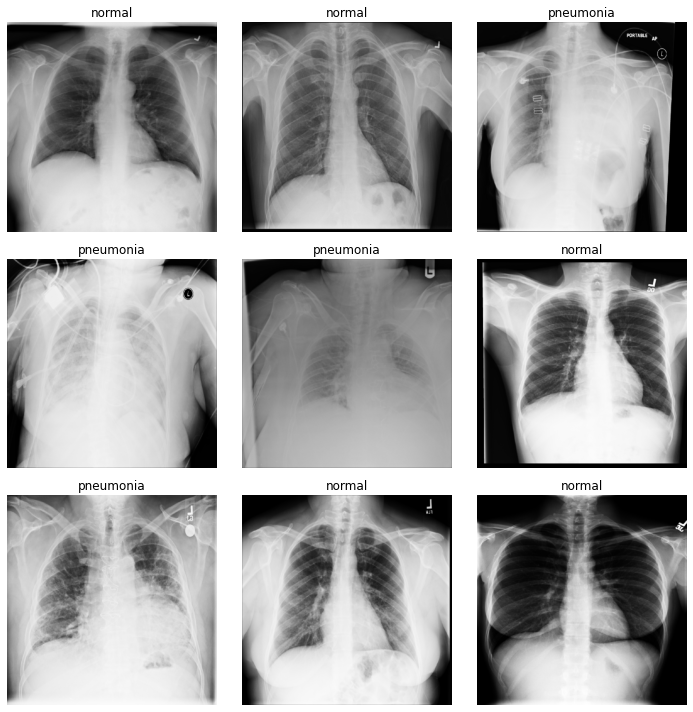

In [11]:
print("Sample Batch, Transformed")
data.show_batch(rows=3, figsize=(10, 10))

In [12]:
# From: https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Args:
        - indices (list, optional): a list of indices
        - num_samples (int, optional): number of samples to draw
    """
    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            for l in label:
                if l in label_to_count:
                    label_to_count[l] += 1
                else: label_to_count[l]=1
        
        # weight for each sample
        weights = [1.0 / min([label_to_count[l] for l in self._get_label(dataset, idx)])
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.y[idx].obj #for category obj
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [13]:
def get_data(sz, tfs, batch=16, workers=4):
  """
  Automates the instantiation of DataLoaders with oversampling of 
  minority class. 
  Args: 
    - sz --> type:int --> img size.
    - tfms --> type:List --> transforms. 
    - batch --> type:int, default=8 --> batch size. 
    - workers --> type:int, default=4 --> number of workers for each dataloader   
  """
  data = ImageDataBunch.from_df(path, 
                                labels, 
                                folder='data/train', 
                                ds_tfms=tfs, fn_col=1, 
                                label_col=2, 
                                size=sz,
                                resize_method=ResizeMethod.SQUISH, 
                                bs=bs)
  data.normalize(imagenet_stats)
  train_ds, val_ds = data.train_ds, data.valid_ds
  sampler = ImbalancedDatasetSampler(train_ds)
  train_dl = DataLoader(train_ds, bs, sampler=sampler, num_workers=workers)
  val_dl = DataLoader(val_ds, 2*bs, False, num_workers=workers)
  
  data = ImageDataBunch(train_dl=train_dl, 
                        valid_dl=val_dl).normalize(imagenet_stats)
  return data

In [14]:
data = get_data(sz=size, tfs=tfms)

Sample Batch, Transformed and Resampled


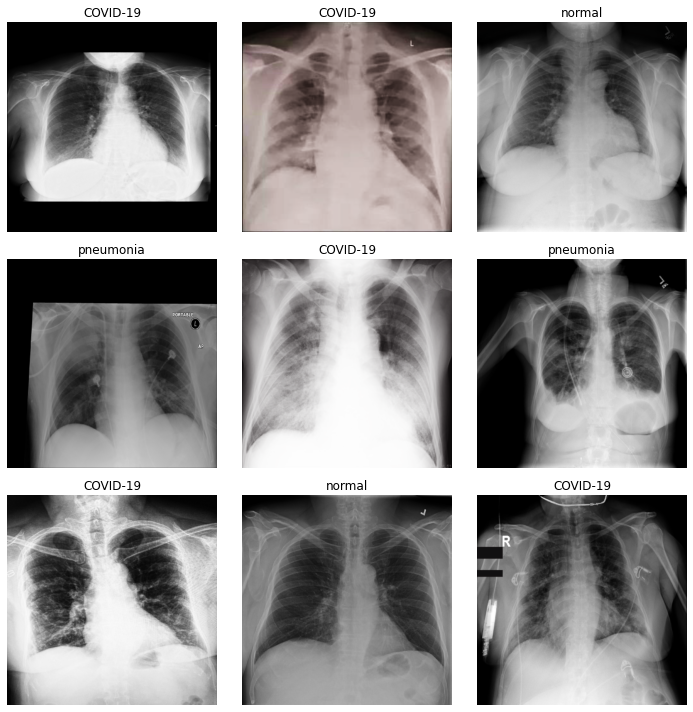

In [15]:
print("Sample Batch, Transformed and Resampled")
data.show_batch(rows=3, figsize=(10, 10))

In [16]:
#Labels
print(f'Labels for this Task: {data.classes}')

Labels for this Task: ['COVID-19', 'normal', 'pneumonia']


In [ ]:
effnet_features = ptcv_get_model("efficientnet_b1", pretrained=True).features

In [18]:
def arch_summary(arch):
  """
  A helper for listing the sequential layer groups of the network
  Args:
    - arch --> type:nn.ModuleList --> A list of modules.
  https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/utils.py
  """
  model = arch(False)
  tot = 0
  for i, l in enumerate(model.children()):
      n_layers = len(flatten_model(l))
      tot += n_layers
      print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(m, layer_groups):
  """
  a helper method for listing the layer groups after the layer cuts have been 
  determined for discriminative learning rates.
  Args:
    - m --> type:nn.ModuleList/nn.Sequential --> A list of modules.
    - layer_groups --> type:list --> List of layers grouped by split defined in 
    Learner class. 
  """
  group_indices = [len(g) for g in layer_groups]
  curr_i = 0
  group = []
  for layer in model:
      group_indices[curr_i] -= len(flatten_model(layer))
      group.append(layer.__class__.__name__)
      if group_indices[curr_i] == 0:
          curr_i += 1
          print(f'Group {curr_i}:', group)   
          group = []

In [19]:
print("Model Blocks:")
arch_summary(lambda _: effnet_features)

Model Blocks:
(0) EffiInitBlock: 3   layers (total: 3)
(1) Sequential  : 20  layers (total: 23)
(2) Sequential  : 39  layers (total: 62)
(3) Sequential  : 39  layers (total: 101)
(4) Sequential  : 104 layers (total: 205)
(5) Sequential  : 91  layers (total: 296)
(6) ConvBlock   : 3   layers (total: 299)
(7) AdaptiveAvgPool2d: 1   layers (total: 300)


In [20]:
print("Model Blocks (Detailed):")
for i in range(len(effnet_features) - 1):
    print(f'---------({i})---------')
    arch_summary(lambda _: effnet_features[i])

Model Blocks (Detailed):
---------(0)---------
(0) ConvBlock   : 3   layers (total: 3)
---------(1)---------
(0) EffiDwsConvUnit: 10  layers (total: 10)
(1) EffiDwsConvUnit: 10  layers (total: 20)
---------(2)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
---------(3)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
---------(4)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  layers (total: 39)
(3) EffiInvResUnit: 13  layers (total: 52)
(4) EffiInvResUnit: 13  layers (total: 65)
(5) EffiInvResUnit: 13  layers (total: 78)
(6) EffiInvResUnit: 13  layers (total: 91)
(7) EffiInvResUnit: 13  layers (total: 104)
---------(5)---------
(0) EffiInvResUnit: 13  layers (total: 13)
(1) EffiInvResUnit: 13  layers (total: 26)
(2) EffiInvResUnit: 13  la

In [21]:
def efficientnet_b1(pretrained=True):
  """
  Returns efficientnet-b1 feature extraction layers, using pytorchcv's
  ptcv_get_model helper method.
  Args:
    pretrained --> type:bool (default: True) 
  """
  return ptcv_get_model("efficientnet_b1", pretrained=pretrained).features

#Fastai Learner (Model with built-in Training Tools)
def get_learner(train_data):
  """
  Generates a fastai Learner with passed fastai ImageDataBunch data loaders and 
  feature extraction layers from a pretrained EfficientNet-b1 network. 
  Uses Half-Tensor Precision.
  Args:
    train_data --> type:ImageDataBunch  
  """
  learn = cnn_learner(train_data, 
                      efficientnet_b1, 
                      metrics=[error_rate, accuracy], 
                      callback_fns=[ShowGraph])
  return learn


In [22]:
#pretrained on ImageNet dataset - weights provided by pytorchcv library 
#data = get_data(size, tfms)
learn = get_learner(data)
print(learn.summary())
print("Loss Function: ", learn.loss_func)

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 225, 225]       864        False     
______________________________________________________________________
BatchNorm2d          [32, 225, 225]       64         True      
______________________________________________________________________
Swish                [32, 225, 225]       0          False     
______________________________________________________________________
Conv2d               [32, 225, 225]       288        False     
______________________________________________________________________
BatchNorm2d          [32, 225, 225]       64         True      
______________________________________________________________________
Swish                [32, 225, 225]       0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [32, 1, 1]           0          False     
___________________________________________________

In [23]:
gc.collect()

39811

In [24]:
#https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai/comments
def wd_grid_search(data, decay_list, frozen=False, plot_y_min=2.00, 
                   plot_y_max=3.80, plot_x_min=1e-6, plot_x_max=1e+00):
  """
  Wraps fastai Learner.Recorder.find_lr() method, loops through decay_list of
  weight decay values and visualizes performance on a test run to help select 
  the optimal amount of decay:
  Args:
    - data --> type:ImageDataBunch 
    - decay_list -> type:List[] -> list of weight decay values to test
    - frozen -> type:bool -> fine-tuning clasifier (True) or entire network (False)
    - plot_y_min, plot_y_max, plot_x_min, plot_x_max -> type:float
      -> ranges for axis of final chart on performance 
  """
  lrs = []
  losses = []
  wds = []

  def reset_learner():
    if frozen:
      learner = get_learner(data)
      learner.freeze()
      return learner
    else:
      learner = get_learner(data)
      learner.unfreeze()
      return learner

  learner = reset_learner()

  #Search w/o weight decay (baseline)
  learner.lr_find(num_it=300)
  lrs.append(learner.recorder.lrs)
  losses.append(learner.recorder.losses)
  wds.append('None')
  learner = reset_learner()

  #for each weight decay value, search for best learning rate 
  for item in decay_list: 
    learner.lr_find(num_it=300, wd=item)
    lrs.append(learner.recorder.lrs)
    losses.append(learner.recorder.losses)
    wds.append(str(item))
    reset_learner()

  #Plot losses for wd values over learning rates  
  _, ax = plt.subplots(1,1)
  min_y = plot_y_min
  max_y = plot_y_max
  min_x = plot_x_min
  max_x = plot_x_max
  for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.isfinite(np.asarray(losses[i])).min(), min_y)
  ax.set_ylabel("Loss")
  ax.set_xlabel("Learning Rate")
  ax.set_xscale('log')
  #ax ranges may need some tuning with different model architectures 
  ax.set_xlim((min_x, max_x))
  ax.set_ylim((min_y, max_y))
  ax.legend(wds)
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [25]:
class TraceMallocMultiColMetric(LearnerCallback):
  """
  #Fastai Learner Callback to measures peak RAM usage during each epoch.
  Callbacks and Custom Metrics, Docs: #https://docs.fast.ai/metrics.html#Creating-your-own-metric
  """
  _order=-20 # Needs to run before the recorder
  def __init__(self, learn):
    super().__init__(learn)
    self.train_max = 0

  def on_train_begin(self, **kwargs):
    self.learn.recorder.add_metric_names(['used', 'max_used', 'peak'])
            
  def on_batch_end(self, train, **kwargs):
    # track max memory usage during the train phase
    if train:
      current, peak =  tracemalloc.get_traced_memory()
      self.train_max = max(self.train_max, current)
        
  def on_epoch_begin(self, **kwargs):
      tracemalloc.start()

  def on_epoch_end(self, last_metrics, **kwargs):
      current, peak =  tracemalloc.get_traced_memory()
      tracemalloc.stop()
      return add_metrics(last_metrics, [current, self.train_max, peak])

### Stage 1: 

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


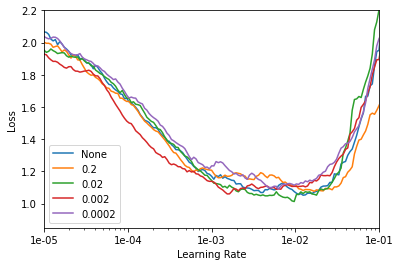

In [27]:
gc.collect()
wd_grid_search(learn.data, 
               [2e-1, 2e-2, 2e-3, 2e-4], 
               frozen=False,
               plot_x_min=float(1e-5), 
               plot_x_max=float(1e-1), 
               plot_y_min=0.85, 
               plot_y_max=2.20)

In [28]:
#garbage collection for gpu memory 
gc.collect() 

6756

epoch,train_loss,valid_loss,error_rate,accuracy,used,max_used,peak,time
0,0.352575,0.309765,0.107991,0.892009,383185,438982,461402,14:03
1,0.307421,0.231492,0.071274,0.928726,233986,438982,306241,09:10
2,0.231832,0.239602,0.087113,0.912887,216335,438982,315788,09:32
3,0.176929,0.173757,0.060835,0.939165,235818,438982,328871,09:20
4,0.083706,0.141832,0.047516,0.952484,262749,438982,347258,09:23
5,0.069053,0.150257,0.046796,0.953204,277072,438982,353537,09:19


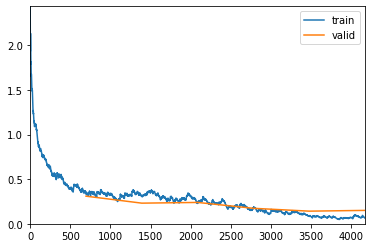

In [29]:
#fit unfrozen, using one-cycle policy:
#appends callback to learners callback list for this run
learn.callbacks.append(TraceMallocMultiColMetric(learn))
learn.unfreeze() 
learn.fit_one_cycle(6, slice(3e-3), wd=2e-2, pct_start=.4) 

In [30]:
#Save checkpoint
learn.save('eff_covid_1')

In [31]:
sample = torch.randn(1, 3, 450, 450).cuda() 
print("FLOPs Count")
count_ops(learn.model, sample, )

FLOPs Count
Operation                   OPS         
--------------------------  ----------  
/onnx::Conv                 45360000    
/onnx::BatchNormalization   3240000     
/onnx::Conv                 14580000    
/onnx::BatchNormalization   3240000     
/onnx::GlobalAveragePool    1620000     
/onnx::Conv                 256         
/onnx::Conv                 256         
/onnx::Mul                  1620000     
/onnx::Conv                 25920000    
/onnx::BatchNormalization   1620000     
/onnx::Conv                 7290000     
/onnx::BatchNormalization   1620000     
/onnx::GlobalAveragePool    810000      
/onnx::Conv                 64          
/onnx::Conv                 64          
/onnx::Mul                  810000      
/onnx::Conv                 12960000    
/onnx::BatchNormalization   1620000     
/onnx::Add                  810000      
/onnx::Conv                 77760000    
/onnx::BatchNormalization   9720000     
/onnx::Conv                 11032416    
/onn

(2576290976,
 [['/onnx::Conv', 45360000],
  ['/onnx::BatchNormalization', 3240000],
  ['/onnx::Conv', 14580000],
  ['/onnx::BatchNormalization', 3240000],
  ['/onnx::GlobalAveragePool', 1620000],
  ['/onnx::Conv', 256],
  ['/onnx::Conv', 256],
  ['/onnx::Mul', 1620000],
  ['/onnx::Conv', 25920000],
  ['/onnx::BatchNormalization', 1620000],
  ['/onnx::Conv', 7290000],
  ['/onnx::BatchNormalization', 1620000],
  ['/onnx::GlobalAveragePool', 810000],
  ['/onnx::Conv', 64],
  ['/onnx::Conv', 64],
  ['/onnx::Mul', 810000],
  ['/onnx::Conv', 12960000],
  ['/onnx::BatchNormalization', 1620000],
  ['/onnx::Add', 810000],
  ['/onnx::Conv', 77760000],
  ['/onnx::BatchNormalization', 9720000],
  ['/onnx::Conv', 11032416],
  ['/onnx::BatchNormalization', 2451648],
  ['/onnx::GlobalAveragePool', 1225824],
  ['/onnx::Conv', 384],
  ['/onnx::Conv', 384],
  ['/onnx::Mul', 1225824],
  ['/onnx::Conv', 29419776],
  ['/onnx::BatchNormalization', 612912],
  ['/onnx::Conv', 44129664],
  ['/onnx::BatchNormal

### Stage 2:

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


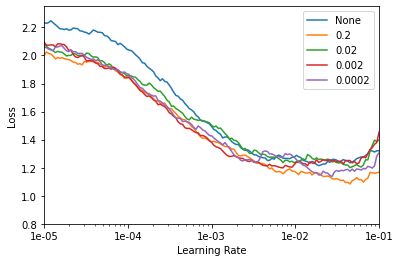

In [33]:
gc.collect()
#random_seed(65)
size=600
data2 = get_data(size, tfms)
learn = get_learner(data2)
learn.load('eff_covid_1')
wd_grid_search(learn.data, 
               [2e-1, 2e-2, 2e-3, 2e-4], #hparam search
               frozen=True, 
               plot_x_max=float(1e-1), 
               plot_x_min=float(1e-5),
               plot_y_min=.80,
               plot_y_max=2.35)

epoch,train_loss,valid_loss,error_rate,accuracy,used,max_used,peak,time
0,0.174029,0.137810,0.043916,0.956084,290484,367043,382314,11:22
1,0.148875,0.122252,0.043557,0.956443,216236,367043,300005,08:27
2,0.133951,0.107489,0.037437,0.962563,232491,367043,309045,08:31
3,0.113365,0.126921,0.044996,0.955004,220786,367043,322498,08:55
4,0.148248,0.116239,0.035637,0.964363,246157,367043,340826,08:37
5,0.091587,0.109376,0.036357,0.963643,262756,367043,352061,08:31


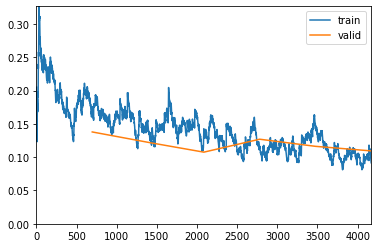

In [35]:
#fit frozen, using one-cycle policy: 
gc.collect()
learn.callbacks.append(TraceMallocMultiColMetric(learn))
learn.freeze()
learn.fit_one_cycle(6, max_lr=slice(2e-3), wd=2e-1, pct_start=.4)

In [36]:
#Save checkpoint
learn.save('eff_covid_2')

In [37]:
print("FLOPs Count:")
sample2 = torch.randn(1, 3, 600, 600).cuda() 
count_ops(learn.model, sample2,)

FLOPs Count:
Operation                   OPS         
--------------------------  ----------  
/onnx::Conv                 80640000    
/onnx::BatchNormalization   5760000     
/onnx::Conv                 25920000    
/onnx::BatchNormalization   5760000     
/onnx::GlobalAveragePool    2880000     
/onnx::Conv                 256         
/onnx::Conv                 256         
/onnx::Mul                  2880000     
/onnx::Conv                 46080000    
/onnx::BatchNormalization   2880000     
/onnx::Conv                 12960000    
/onnx::BatchNormalization   2880000     
/onnx::GlobalAveragePool    1440000     
/onnx::Conv                 64          
/onnx::Conv                 64          
/onnx::Mul                  1440000     
/onnx::Conv                 23040000    
/onnx::BatchNormalization   2880000     
/onnx::Add                  1440000     
/onnx::Conv                 138240000   
/onnx::BatchNormalization   17280000    
/onnx::Conv                 19440000    
/on

(4342704048,
 [['/onnx::Conv', 80640000],
  ['/onnx::BatchNormalization', 5760000],
  ['/onnx::Conv', 25920000],
  ['/onnx::BatchNormalization', 5760000],
  ['/onnx::GlobalAveragePool', 2880000],
  ['/onnx::Conv', 256],
  ['/onnx::Conv', 256],
  ['/onnx::Mul', 2880000],
  ['/onnx::Conv', 46080000],
  ['/onnx::BatchNormalization', 2880000],
  ['/onnx::Conv', 12960000],
  ['/onnx::BatchNormalization', 2880000],
  ['/onnx::GlobalAveragePool', 1440000],
  ['/onnx::Conv', 64],
  ['/onnx::Conv', 64],
  ['/onnx::Mul', 1440000],
  ['/onnx::Conv', 23040000],
  ['/onnx::BatchNormalization', 2880000],
  ['/onnx::Add', 1440000],
  ['/onnx::Conv', 138240000],
  ['/onnx::BatchNormalization', 17280000],
  ['/onnx::Conv', 19440000],
  ['/onnx::BatchNormalization', 4320000],
  ['/onnx::GlobalAveragePool', 2160000],
  ['/onnx::Conv', 384],
  ['/onnx::Conv', 384],
  ['/onnx::Mul', 2160000],
  ['/onnx::Conv', 51840000],
  ['/onnx::BatchNormalization', 1080000],
  ['/onnx::Conv', 77760000],
  ['/onnx::Batc

### Save Weights

### Analysis
Using Fast.ai **ClassificationInterpretation** class to aggregate performance metrics and other insights. 

Docs for ClassificationInterpretation: https://docs.fast.ai/vision.learner.html#ClassificationInterpretation

In [38]:
class ImageEmbeddings(): 
  '''
  PyTorch Hook for storing linear features of images.
  Args:
    - m --> type:nn.Module --> Linear Layer of model. 
  '''
  features=None
  def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None

  def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))

  def remove(self): 
        self.hook.remove()


In [39]:
def df_for_projection(dataset, train_set=True):
  """
  Generates a DF from Fastai ImageDataBunch.
  Args:
    - dataset -> type:ImageDataBunch --> Learner data.
    - train_set -> type:bool --> Indicates whether training or test set 
  """
  df=None
  if train_set:
    img_path = [str(x) for x in (list(dataset.train_ds.items) +list(dataset.valid_ds.items))]
    label = [dataset.classes[x] for x in (list(dataset.train_ds.y.items) +list(dataset.valid_ds.y.items))]
    label_id = [x for x in (list(dataset.train_ds.y.items) +list(dataset.valid_ds.y.items))]
    df = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
  else: 
    img_path = [str(x) for x in (list(dataset.test_ds.items))]
    label = [dataset.classes[x] for x in (list(dataset.test_ds.y.items))]
    label_id = [x for x in (list(dataset.test_ds.y.items))]
    df = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
  return df 

In [40]:
def append_features(proj_df, embeddings):
  """
  Appends a new column of ImageEmbeddings to projection DF.
  Args:
  - proj_df -> type:DataFrame --> projection DF.
  - embeddings -> type:list --> List of linear features from a model.
  """
  feature_vector = np.array(embeddings.features)
  x=feature_vector.tolist()
  proj_df['img_repr'] = x
  return proj_df

In [41]:
def project_data(df, components=3, perplexity=50, iterate=500):
  """
  Automates performing TSNE on a projection DF, and apppending 
  results for each component as a new column on the projection DF.
  Args:
  - df --> type:DataFrame --> projection DF
  - components, perplexity, iterate --> type:int --> TSNE hyperparams. 
  """
  img_repr_matrix = [list(x) for x in df['img_repr'].values]
  tsne = TSNE(n_components=components, 
                    verbose=10, 
                    init='pca', 
                    perplexity=perplexity, 
                    n_iter=iterate, 
                    n_iter_without_progress=100)
  
  tsne_results_3 = tsne.fit_transform(img_repr_matrix)
  df['tsne1'] = tsne_results_3[:,0]
  df['tsne2'] = tsne_results_3[:,1]
  df['tsne3'] = tsne_results_3[:,2]
  return df

In [42]:
train_projection_df = df_for_projection(learn.data)
train_projection_df.head()

,img_path,label,label_id
0,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2
1,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2
2,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2
3,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2
4,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2


In [43]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [44]:
#Run through training set one time to hook embeddings
train_features = learn.model[1][4]
train_embeddings = ImageEmbeddings(train_features)
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [45]:
print(f'Train Embedding Size: {len(train_embeddings.features)}')

Train Embedding Size: 13893


In [46]:
train_projection_df = append_features(train_projection_df, train_embeddings)
train_projection_df.head()

,img_path,label,label_id,img_repr
0,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2,"[-11.975935935974121, 8.023313522338867, 3.468..."
1,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2,"[-6.902647018432617, -2.8418447971343994, -1.7..."
2,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2,"[1.0871294736862183, -4.631300926208496, 4.050..."
3,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2,"[-9.10018253326416, -2.4368999004364014, -0.19..."
4,/content/drive/My Drive/mle_cap_final/data/tra...,pneumonia,2,"[7.609682083129883, -21.493680953979492, 22.08..."


In [47]:
train_projection_df = project_data(train_projection_df)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 13893 samples in 1.193s...
[t-SNE] Computed neighbors for 13893 samples in 32.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13893
[t-SNE] Computed conditional probabilities for sample 2000 / 13893
[t-SNE] Computed conditional probabilities for sample 3000 / 13893
[t-SNE] Computed conditional probabilities for sample 4000 / 13893
[t-SNE] Computed conditional probabilities for sample 5000 / 13893
[t-SNE] Computed conditional probabilities for sample 6000 / 13893
[t-SNE] Computed conditional probabilities for sample 7000 / 13893
[t-SNE] Computed conditional probabilities for sample 8000 / 13893
[t-SNE] Computed conditional probabilities for sample 9000 / 13893
[t-SNE] Computed conditional probabilities for sample 10000 / 13893
[t-SNE] Computed conditional probabilities for sample 11000 / 13893
[t-SNE] Computed conditional probabilities for sample 12000 / 13893
[t-SNE] Computed conditional probabilities for s

In [48]:
#Visualize Img Distribution in 3 Dimensions
train_projection_df.to_parquet('similar_images')
px.scatter_3d(train_projection_df, 
              x='tsne1', 
              y='tsne2', 
              z='tsne3', 
              color='label', 
              title="Train Set Distribution - Scatter Plot")

In [49]:
train_projection_df.describe()

,label_id,tsne1,tsne2,tsne3
count,13893.000000,13893.000000,13893.000000,13893.000000
mean,1.358526,-0.118535,-0.068027,-0.071834
std,0.545984,371.060181,306.236084,94.450165
min,0.000000,-1156.285400,-497.206970,-243.185684
25%,1.000000,-203.549957,-259.607788,-78.398254
50%,1.000000,-81.161369,-4.273879,-6.475988
75%,2.000000,108.724785,146.295334,77.567047
max,2.000000,2272.311279,1665.314575,398.048767


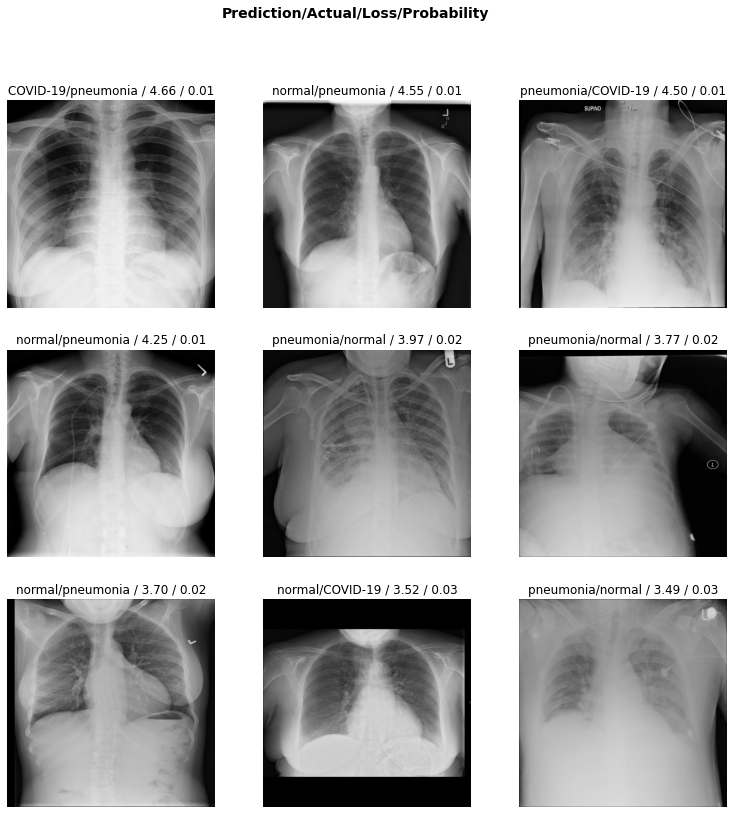

In [50]:
'''
plot_top_losses() --> https://docs.fast.ai/vision.learner.html#_cl_int_plot_top_losses
Show images in top_losses along with their prediction, actual, loss, 
and probability of actual class.
'''
interp.plot_top_losses(9, figsize=(13,13))

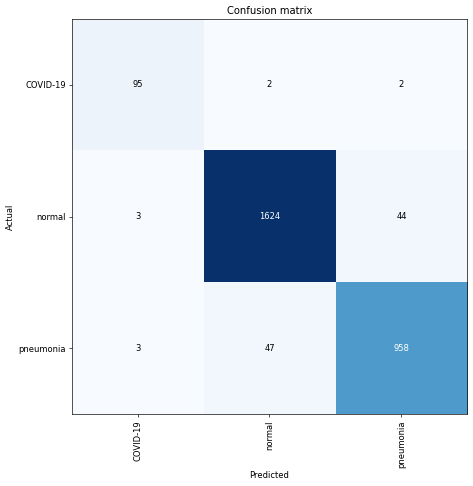

In [51]:
'''
plot_confusion_matrix() --> 
https://docs.fast.ai/train.html#ClassificationInterpretation.plot_confusion_matrix
Plot the confusion matrix, with title and using cmap.
'''
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [52]:
'''
most_confused() --> 
https://docs.fast.ai/train.html#ClassificationInterpretation.most_confused
Sorted descending list of largest non-diagonal entries of confusion matrix, 
presented as actual, predicted, number of occurrences.
'''
print("Most Confused Classes")
interp.most_confused(min_val=2)

Most Confused Classes


[('pneumonia', 'normal', 47),
 ('normal', 'pneumonia', 44),
 ('normal', 'COVID-19', 3),
 ('pneumonia', 'COVID-19', 3),
 ('COVID-19', 'normal', 2),
 ('COVID-19', 'pneumonia', 2)]

In [53]:
print(interp.confusion_matrix())

[[  95    2    2]
 [   3 1624   44]
 [   3   47  958]]


In [54]:
def get_metrics(cm):
  """
  Tabulates relevant metrics for medical diagnosis from stored rows/diagonal 
  entries of confusion matrics; Returns an array of metrics:true positives (tp), 
  false positives (fp), true negatives (tn), and false negatives (fn) for each
  class in a 3x3 confusion matrix (12 int64 values).
  Args:
    cm --> type:np.darray --> a confusion matrix.
  """
  tp_c1 = cm[0][0]
  fp_c1 = cm[1][0] + cm[2][0]
  tn_c1 = np.sum(cm) - tp_c1
  fn_c1 = cm[0][1] + cm[0][2]

  tp_c2 = cm[1][1]
  fp_c2 = cm[0][1] + cm[2][1]
  tn_c2 = np.sum(cm) - tp_c2
  fn_c2 = cm[1][0] + cm[1][2]

  tp_c3 = cm[2][2]
  fp_c3 = cm[0][2] + cm[1][2]
  tn_c3 = np.sum(cm) - tp_c3
  fn_c3 = cm[2][0] + cm[2][1]

  return [tp_c1,fp_c1,tn_c1,fn_c1,tp_c2,fp_c2,tn_c2,fn_c2, tp_c3,fp_c3,tn_c3,fn_c3]




In [55]:
train_conf_matrix = interp.confusion_matrix()
training_metrics = get_metrics(train_conf_matrix)
print(training_metrics)

[95, 6, 2683, 4, 1624, 49, 1154, 47, 958, 46, 1820, 50]


In [56]:
#Precision for each class 
covid_precision = training_metrics[0]/(training_metrics[0]+training_metrics[1])
norm_precision = training_metrics[4]/(training_metrics[4]+training_metrics[5])
pneum_precision = training_metrics[8]/(training_metrics[8]+training_metrics[9])

train_precision_scores = {
    "COVID-19": covid_precision,
    "NORMAL": norm_precision,
    "PNEUMONIA": pneum_precision
}

train_precision_scores = pd.DataFrame(train_precision_scores, 
                                      columns=train_precision_scores.keys(), 
                                      index=[0])
print("Precision Scores:")
train_precision_scores

Precision Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.940594,0.970711,0.954183


In [57]:
#Recall for each class 
covid_recall = training_metrics[0]/(training_metrics[0]+training_metrics[3])
norm_recall = training_metrics[4]/(training_metrics[4]+training_metrics[7])
pneum_recall = training_metrics[8]/(training_metrics[8]+training_metrics[11])

train_sensitivity_scores = {
    "COVID-19": covid_recall, 
    "NORMAL": norm_recall,
    "PNEUMONIA": pneum_recall
}

train_sensitivity_scores = pd.DataFrame(train_sensitivity_scores, 
                         columns=train_sensitivity_scores.keys(), 
                         index=[0])
print("Sensitivity Scores:")
train_sensitivity_scores

Sensitivity Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.959596,0.971873,0.950397


In [58]:
#F1 Score for each class 
covid_f1 = 2*(covid_precision*covid_recall)/(covid_precision+covid_recall)
norm_f1 = 2 * (norm_precision*norm_recall)/(norm_precision + norm_recall)
pneum_f1 = 2 * (pneum_precision*pneum_recall)/(pneum_precision+pneum_recall)

train_f1_scores = {
    "COVID-19": covid_f1,
    "NORMAL": norm_f1,
    "PNEUMONIA": pneum_f1
}

train_f1_scores = pd.DataFrame(train_f1_scores, 
                         columns=train_f1_scores.keys(), 
                         index=[0])
print("F1 Scores:")
train_f1_scores

F1 Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.95,0.971292,0.952286


In [59]:
#Specificity for each class 
covid_specificity = training_metrics[2]/(training_metrics[2]+training_metrics[1])
norm_specificity = training_metrics[6]/(training_metrics[6]+training_metrics[5])
pneum_specificity = training_metrics[10]/(training_metrics[10]+training_metrics[9])

specificity_scores = {"COVID-19": covid_specificity, 
                      "NORMAL": norm_specificity, 
                      "PNEUMONIA": pneum_specificity}
                      
specificity_df = pd.DataFrame(specificity_scores, 
                              columns=specificity_scores.keys(), 
                              index=[0])
print("Specificity Scores:")
specificity_df

Specificity Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.997769,0.959268,0.975348


### Inference Test & Results:

In [60]:
test_labels = pd.read_csv(path/'data/test_split_v3.csv', header='infer')
test_data_df = test_labels[["fname", "label"]]
print("Test Set Labels:")
test_data_df.head()

Test Set Labels:


,fname,label
0,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia
1,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
2,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
3,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia
4,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia


In [61]:
#Create a Fast.ai ImageList for creating inference data loaders
il = ImageList.from_df(test_data_df, path/'data/test')
ils = il.split_none()
ll = ils.label_from_df()
ll.valid = ll.train
ll.test = ll.train

In [62]:
#Apply test time transforms (None) 
test_size = 600
ll.transform(tfms=tfms,size=test_size)
#Create DataLoaders 
test_data = ll.databunch(bs=bs)
#Normalize --> Imagenet Stats 
test_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1579 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/mle_cap_final/data/test;

Valid: LabelList (1579 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/mle_cap_final/data/test;

Test: LabelList (1579 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /content/drive/My Drive/mle_cap_final/data/test

In [63]:
#Load serialized learner and weights
learn.export(file=path/'e-covidnet.pkl')
test_learn = load_learner(path, file='e-covidnet.pkl')
#Attach test data to Learner 
test_learn.data = test_data

In [64]:
test_features = test_learn.model[1][4]
test_embeddings = ImageEmbeddings(test_features)

In [65]:
#Run inference
%time results = test_learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 11.6 s, sys: 6.92 s, total: 18.5 s
Wall time: 4min 38s


In [66]:
print(f'Test Embedding Size: {len(test_embeddings.features)}')

Test Embedding Size: 1579


In [67]:
testing_projection_df = df_for_projection(test_learn.data, train_set=False)
testing_projection_df.head()

,img_path,label,label_id
0,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2
1,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2
2,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2
3,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2
4,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2


In [68]:
testing_projection_df = append_features(testing_projection_df, test_embeddings)
testing_projection_df.head()

,img_path,label,label_id,img_repr
0,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2,"[12.674925804138184, 10.67092227935791, -8.613..."
1,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2,"[-9.793478012084961, 7.8267693519592285, -3.91..."
2,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2,"[-16.203664779663086, 7.976696014404297, 0.541..."
3,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2,"[-11.223784446716309, 15.686614036560059, -10...."
4,/content/drive/My Drive/mle_cap_final/data/tes...,pneumonia,2,"[-17.84762191772461, 6.733975410461426, -1.282..."


In [69]:
testing_projection_df = project_data(testing_projection_df)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1579 samples in 0.056s...
[t-SNE] Computed neighbors for 1579 samples in 1.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1579
[t-SNE] Computed conditional probabilities for sample 1579 / 1579
[t-SNE] Mean sigma: 28.329707
[t-SNE] Computed conditional probabilities in 0.192s
[t-SNE] Iteration 50: error = 54.5673523, gradient norm = 0.0019075 (50 iterations in 2.182s)
[t-SNE] Iteration 100: error = 86.7594299, gradient norm = 0.0110943 (50 iterations in 2.034s)
[t-SNE] Iteration 150: error = 110.0953979, gradient norm = 0.0129026 (50 iterations in 1.682s)
[t-SNE] Iteration 200: error = 111.2901459, gradient norm = 0.0097210 (50 iterations in 1.445s)
[t-SNE] Iteration 250: error = 111.9426575, gradient norm = 0.0161949 (50 iterations in 1.374s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.942657
[t-SNE] Iteration 300: error = 1.9471068, gradient norm = 0.0003706 (50 iterations in 1

In [70]:
#Visualize Img Distribution in 3 Dimensions
testing_projection_df.to_parquet('similar_images')
px.scatter_3d(testing_projection_df, 
              x='tsne1', 
              y='tsne2', 
              z='tsne3', 
              color='label', 
              title="Test Set Distribution - Scatter Plot")

In [71]:
testing_projection_df.describe()

,label_id,tsne1,tsne2,tsne3
count,1579.000000,1579.000000,1579.000000,1579.000000
mean,1.312856,-0.519371,-0.183029,-0.198344
std,0.584685,439.498016,269.179657,72.817375
min,0.000000,-990.662415,-523.548645,-234.486694
25%,1.000000,-252.217171,-157.574593,-51.469576
50%,1.000000,-141.203369,-52.319725,-9.015071
75%,2.000000,148.781471,104.572750,38.514585
max,2.000000,1945.252319,1357.113037,288.552765


### Inference Test Results

In [72]:
#store rows/diagonal entries of confusion matrics to tabulate metrics
test_interp = ClassificationInterpretation.from_learner(test_learn)
losses,idxs = test_interp.top_losses()
len(test_data.test_ds)==len(losses)==len(idxs)

True

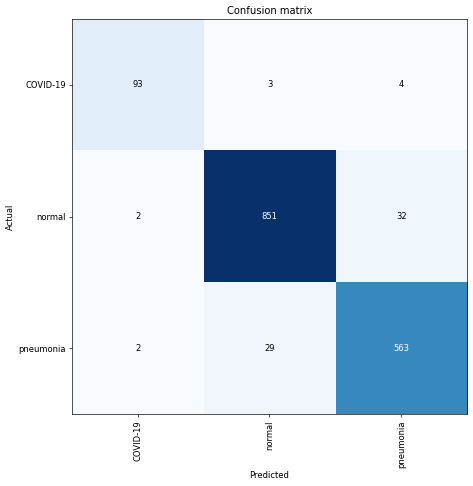

In [73]:
test_interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [74]:
test_interp.most_confused(min_val=2)

[('normal', 'pneumonia', 32),
 ('pneumonia', 'normal', 29),
 ('COVID-19', 'pneumonia', 4),
 ('COVID-19', 'normal', 3),
 ('normal', 'COVID-19', 2),
 ('pneumonia', 'COVID-19', 2)]

In [75]:
test_conf_matrix = test_interp.confusion_matrix()
inference_metrics = get_metrics(test_conf_matrix)
print(inference_metrics)

[93, 4, 1486, 7, 851, 32, 728, 34, 563, 36, 1016, 31]


In [76]:
#Precision for each class 
test_covid_precision = inference_metrics[0]/(inference_metrics[0]+inference_metrics[1])
test_norm_precision = inference_metrics[4]/(inference_metrics[4]+inference_metrics[5])
test_pneum_precision = inference_metrics[8]/(inference_metrics[8]+inference_metrics[9])

test_precision_scores = {
    "COVID-19": test_covid_precision,
    "NORMAL": test_norm_precision,
    "PNEUMONIA": test_pneum_precision
}

test_precision_scores = pd.DataFrame(test_precision_scores, 
                                      columns=train_precision_scores.keys(), 
                                      index=[0])
print("Precision Scores:")
test_precision_scores

Precision Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.958763,0.96376,0.9399


In [77]:
#Recall for each class 
test_covid_recall = inference_metrics[0]/(inference_metrics[0]+inference_metrics[3])
test_norm_recall = inference_metrics[4]/(inference_metrics[4]+inference_metrics[7])
test_pneum_recall = inference_metrics[8]/(inference_metrics[8]+inference_metrics[11])

test_sensitivity_scores = {
    "COVID-19": test_covid_recall, 
    "NORMAL": test_norm_recall,
    "PNEUMONIA": test_pneum_recall
}

test_sensitivity_scores = pd.DataFrame(test_sensitivity_scores, 
                         columns=test_sensitivity_scores.keys(), 
                         index=[0])
print("Sensitivity Scores:")
test_sensitivity_scores

Sensitivity Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.93,0.961582,0.947811


In [78]:
#F1 Score for each class 
test_covid_f1 = 2*(test_covid_precision*test_covid_recall)/(test_covid_precision+test_covid_recall)
test_norm_f1 = 2 * (test_norm_precision*test_norm_recall)/(test_norm_precision + test_norm_recall)
test_pneum_f1 = 2 * (test_pneum_precision*test_pneum_recall)/(test_pneum_precision+test_pneum_recall)

test_f1_scores = {
    "COVID-19": test_covid_f1,
    "NORMAL": test_norm_f1,
    "PNEUMONIA": test_pneum_f1
}

test_f1_scores = pd.DataFrame(test_f1_scores, 
                         columns=test_f1_scores.keys(), 
                         index=[0])
print("F1 Scores:")
test_f1_scores

F1 Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.944162,0.96267,0.943839


In [79]:
#Specificity for each class 
test_covid_specificity = inference_metrics[2]/(inference_metrics[2]+inference_metrics[1])
test_norm_specificity = inference_metrics[6]/(inference_metrics[6]+inference_metrics[5])
test_pneum_specificity = inference_metrics[10]/(inference_metrics[10]+inference_metrics[9])

test_specificity_scores = {"COVID-19": test_covid_specificity, 
                      "NORMAL": test_norm_specificity, 
                      "PNEUMONIA": test_pneum_specificity}
                      
test_specificity_df = pd.DataFrame(test_specificity_scores, 
                              columns=test_specificity_scores.keys(), 
                              index=[0])
print("Specificity Scores:")
test_specificity_df

Specificity Scores:


,COVID-19,NORMAL,PNEUMONIA
0,0.997315,0.957895,0.965779


In [83]:
accuracy(results[0], results[1])

tensor(0.9544)

In [81]:
#save serialized fastai learner and recorder info
#import torch
defaults.device = torch.device('cpu')
#learn = get_learner(data2).load('eff_covid_2')
learn.export(file=path/'e-covidnet.pkl')
#save model state/weights (.pth file) for cpu inference
torch.save(learn.model.state_dict(), path/"e-covidnet.pth")

In [82]:
#Compress model files for use in FastAPI
import shutil
shutil.make_archive('models', 'zip', 'models')

'/content/models.zip'